# Deep learning 1

## introductie
In deze notebook ga ik cifar-10 gebruiken om met een convolutional model foto's bij categorie te kunnen raden.
Cifar-10 is een dataset van 600000 32X32 kleur foto's met 6000 foto's per klass.
Hierdoor weten we dat er 10 verschillende klassen zijn (vandaar cifar-**10**)
## Imports

In [121]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D
from tensorflow.python.keras.models import Sequential

## Unpickle
The data is compressed in pickled files. For access the data needs to be unpickled first. This funciton unpickles the
data and returns a `dict` of the data.

In [122]:
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.optimizer_v2.gradient_descent import SGD
from tensorflow.python.keras.utils.np_utils import to_categorical


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [123]:
def load_train():
    unpict = unpickle("./cifar-10-batches-py/data_batch_2")
    x = unpict.get(b'data')
    y = unpict.get(b'labels')
    for i in range(2,6):
        unpict = unpickle("./cifar-10-batches-py/data_batch_" + str(i))
        y = np.concatenate((y, np.array(unpict.get(b'labels'))))
        x = np.concatenate((x,np.array(unpict.get(b'data'))))
    return x, y

def values_to_image(x):
    new_array =[]
    for i in range(0,len(x)):
        img_flat = x[i]
        img_R = img_flat[0:1024].reshape((32, 32))
        img_G = img_flat[1024:2048].reshape((32, 32))
        img_B = img_flat[2048:3072].reshape((32, 32))
        new_array.append(np.dstack((img_R, img_G, img_B)))
    return np.array(new_array)
def normalize_values(data, amount):
    newValues = []
    for i in range(0,len(data)):
        newValues.append(data[i]/amount)
    return np.array(newValues)


## Laden van de data

In [124]:
X_train, y_train = load_train()
X_train = values_to_image(X_train)
test = unpickle("./cifar-10-batches-py/test_batch")
X_test = test.get(b'data')
X_test = values_to_image(X_test)
y_test = test.get(b'labels')

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Normaliseren data
De waardes die gegeven zijn in de data hebben nu nog de waardes van 0 t/m 255 (rgb waardes). Dit moet genormaliseerd
worden voor het trainen van het model. De reden hiervoor is omdat het makkelijker te begrijpen is voor het model en
het transfer geeft betere resultaten voor het verder verwerken van het model.

In [125]:
X_train_norm, X_test_norm =normalize_values(X_train,255) , normalize_values(X_test,255)

## preprocess data transfer model
De train set voor het transfer model wordt hier gemaakt. Hiervoor wordt de data eerst voorbereid voor de model om het
leesbaar te maken voor het model zelf.

In [126]:
X_train_pr, y_train = vgg16.preprocess_input(X_train), to_categorical(y_train,10)
X_test_pr, y_test = vgg16.preprocess_input(X_test), to_categorical(y_test,10)
transfer_model = vgg16.VGG16(include_top=False,weights="imagenet",input_shape=X_train[0].shape)


## Conventional model

In [148]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform', padding='same',input_shape=(32,32,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation="relu", kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=SGD(lr=0.1,momentum=0.9),loss="categorical_crossentropy",metrics=["accuracy"])



In [147]:
history_model = model.fit(X_train_norm,y_train ,batch_size=128, epochs=20,shuffle=True,
                          validation_data=(X_test_norm,y_test), callbacks=EarlyStopping(patience=5))

Epoch 1/20
391/391 [==============================] - 5s 9ms/step - loss: 2.2775 - accuracy: 0.1402 - val_loss: 2.3044 - val_accuracy: 0.1001

## plots

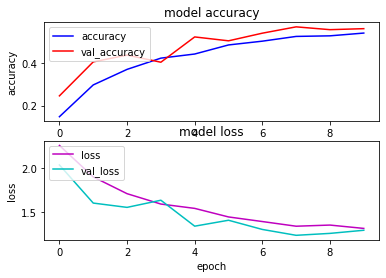

In [142]:
s, (at, al) = plt.subplots(2,1)
at.plot(history_model.history['accuracy'], c= 'b')
at.plot(history_model.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['accuracy', 'val_accuracy'], loc='upper left')

al.plot(history_model.history['loss'], c='m')
al.plot(history_model.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['loss', 'val_loss'], loc = 'upper left')

In [145]:
test_loss, test_acc = model.evaluate(X_test_norm,  y_test, verbose=2)
print(test_acc)

313/313 - 1s - loss: 1.2908 - accuracy: 0.5790
0.5789999961853027


## Conclusion
Ik had veel moeite om een mooi model neer te zetten. Ik liep tegen het probleem aan dat ik het model veel te complex had
gemaakt. Na wat lagen te verwijderen en een dropout te gebruiken voor het voorkomen van overfitting op de training set,
is het aanzienlijk beter geworden. De geplotte waarden zijn ook veel beter en zijn ook minder sporen van overfitting of
underfitting.

## Literatuur
Dataset:
https://www.cs.toronto.edu/~kriz/cifar.html